In [1]:
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision.datasets import Omniglot
from torchvision.transforms import Compose, Resize, ToTensor, Lambda
from torch.utils.data import DataLoader, TensorDataset
import random, collections, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
SEED = 0
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True


device: cuda


In [3]:
# 하이퍼파라미터
WAYS_LIST          = [5, 20]
SHOTS_LIST         = [1, 5]
QUERIES            = 15
EPOCHS             = 1
TASKS_PER_EPOCH    = 50
INNER_STEPS        = 5
HIDDEN             = 64
LR_INNER, LR_OUTER = 0.01, 1e-3
EPOCHS_FT          = 10
BATCH_SIZE_FT      = 64

# Omniglot split
tf   = Compose([Resize((28,28)), ToTensor(), Lambda(lambda x:1-x)])
omni = Omniglot("./data", download=True, background=True, transform=tf)

cls2imgs={}
for img,lbl in omni:
    cls2imgs.setdefault(lbl,[]).append(img)

cls_all=list(cls2imgs); random.shuffle(cls_all)
n_tr=int(0.6*len(cls_all)); n_val=int(0.2*len(cls_all))
train_cls, val_cls, test_cls = cls_all[:n_tr], cls_all[n_tr:n_tr+n_val], cls_all[n_tr+n_val:]

def sample_tasks(pool, ways, shots, qs, n_tasks):
    tasks=[]
    for _ in range(n_tasks):
        classes=random.sample(pool, ways)
        sx=sy=qx=qy=None
        sx,sy,qx,qy=[],[],[],[]
        for i,c in enumerate(classes):
            imgs=random.sample(cls2imgs[c], shots+qs)
            sx+=imgs[:shots]; qx+=imgs[shots:]
            sy+=[i]*shots;    qy+=[i]*qs
        tasks.append((torch.stack(sx), torch.tensor(sy),
                      torch.stack(qx), torch.tensor(qy)))
    return tasks


In [4]:
# ── Backbone ───────────────────────────────────────────────────
class ConvBlock(nn.Module):
    def __init__(self,c_in,c_out):
        super().__init__()
        self.net=nn.Sequential(
            nn.Conv2d(c_in,c_out,3,padding=1),
            nn.BatchNorm2d(c_out),
            nn.ReLU(True),
            nn.MaxPool2d(2))
    def forward(self,x): return self.net(x)

class ConvNet(nn.Module):
    def __init__(self,in_c,n_cls,hidden=64):
        super().__init__()
        self.encoder=nn.Sequential(*(ConvBlock(in_c if i==0 else hidden,hidden) for i in range(4)))
        self.classifier=nn.Linear(hidden,n_cls)
    def forward(self,x):
        x=self.encoder(x)
        x=x.view(x.size(0),-1)
        return self.classifier(x)

# ── MAML ───────────────────────────────────────────────────────
class MAML:
    def __init__(self,model,lr_i,lr_o,K):
        self.model=model.to(device); self.K=K; self.lr_i=lr_i
        self.opt=torch.optim.Adam(model.parameters(),lr=lr_o)
        self.loss=nn.CrossEntropyLoss()
    def _adapt(self,x,y):
        fast=collections.OrderedDict(self.model.named_parameters())
        for _ in range(self.K):
            loss=self.loss(self.model(x),y)
            grads=torch.autograd.grad(loss,self.model.parameters(),create_graph=True)
            fast=collections.OrderedDict((n,w-self.lr_i*g) for (n,w),g in zip(fast.items(),grads))
        return fast
    def _fwd(self,x,p=None):
        if p is None: return self.model(x)
        x=self.model.encoder(x); x=x.view(x.size(0),-1)
        return F.linear(x,p['classifier.weight'],p['classifier.bias'])
    def meta_train(self,tasks,verbose=False):
        acc=[]
        for i,(sx,sy,qx,qy) in enumerate(tasks,1):
            sx,sy,qx,qy=(t.to(device) for t in (sx,sy,qx,qy))
            fast=self._adapt(sx,sy)
            logits=self._fwd(qx,fast); loss=self.loss(logits,qy)
            self.opt.zero_grad(); loss.backward(); self.opt.step()
            ep_acc=(logits.argmax(1)==qy).float().mean().item()
            if verbose and i%10==0:
                print(f"    [MAML   ] ep {i:03d}: {ep_acc*100:4.1f}%")
            acc.append(ep_acc)
        return float(np.mean(acc))

# ── Meta-SGD ───────────────────────────────────────────────────
class MetaSGD:
    def __init__(self,model,init_a,lr_o,K):
        self.model=model.to(device); self.K=K; self.loss=nn.CrossEntropyLoss()
        self.alpha=nn.ParameterDict({n.replace('.','_'): nn.Parameter(torch.full_like(p,init_a))
                                     for n,p in model.named_parameters()})
        self.opt=torch.optim.Adam(list(model.parameters())+list(self.alpha.parameters()), lr=lr_o)
    def _fwd(self,x,p=None):
        if p is None: return self.model(x)
        x=self.model.encoder(x); x=x.view(x.size(0),-1)
        return F.linear(x,p['classifier.weight'],p['classifier.bias'])
    def _adapt(self, x, y):
        fast = collections.OrderedDict(self.model.named_parameters())
        for _ in range(self.K):
            loss = self.loss(self._fwd(x, fast), y)
            grads = torch.autograd.grad(loss, fast.values(), create_graph=True, allow_unused=True)
            fast = collections.OrderedDict(
                (n, w - self.alpha[n.replace('.', '_')] * g if g is not None else w)
                for (n, w), g in zip(fast.items(), grads)
            )
        return fast
    def meta_train(self,tasks,verbose=False):
        acc=[]
        for i,(sx,sy,qx,qy) in enumerate(tasks,1):
            sx,sy,qx,qy=(t.to(device) for t in (sx,sy,qx,qy))
            fast=self._adapt(sx,sy)
            logits=self._fwd(qx,fast); loss=self.loss(logits,qy)
            self.opt.zero_grad(); loss.backward(); self.opt.step()
            ep_acc=(logits.argmax(1)==qy).float().mean().item()
            if verbose and i%10==0:
                print(f"    [Meta-SGD] ep {i:03d}: {ep_acc*100:4.1f}%")
            acc.append(ep_acc)
        return float(np.mean(acc))

# ── ProtoNet + loss ────────────────────────────────────────────
class ProtoNet(nn.Module):
    def __init__(self,enc): super().__init__(); self.encoder=enc
    def forward(self,x): return self.encoder(x)

def prototypical_loss(model,sx,sy,qx,qy):
    emb_s,emb_q=model(sx),model(qx)
    n_way=int(sy.max())+1
    protos=torch.stack([emb_s[sy==c].mean(0) for c in range(n_way)])
    logits=-((emb_q[:,None,:]-protos[None,:,:])**2).sum(-1)
    loss=F.cross_entropy(logits,qy)
    acc =(logits.argmax(1)==qy).float().mean().item()
    return loss,acc


In [5]:
results={}
for ways in WAYS_LIST:
    for shots in SHOTS_LIST:
        setting=f"{ways}-way {shots}-shot"
        print(f"\n=== {setting} ===")
        maml = MAML(ConvNet(1,ways,HIDDEN), LR_INNER, LR_OUTER, INNER_STEPS)
        meta = MetaSGD(ConvNet(1,ways,HIDDEN), 0.1, LR_OUTER, INNER_STEPS)
        proto= ProtoNet(ConvNet(1,ways,HIDDEN).to(device))
        proto_opt=torch.optim.Adam(proto.parameters(),1e-3)

        for ep in range(1, EPOCHS+1):
            tasks = sample_tasks(val_cls, ways, shots, QUERIES, TASKS_PER_EPOCH)

            maml_acc = maml.meta_train(tasks, verbose=(ep==1))
            meta_acc = meta.meta_train(tasks, verbose=(ep==1))

            # ProtoNet 학습
            acc_p=[]; proto.train()
            for sx,sy,qx,qy in tasks:
                sx,sy,qx,qy=(t.to(device) for t in (sx,sy,qx,qy))
                loss,acc=prototypical_loss(proto,sx,sy,qx,qy)
                proto_opt.zero_grad(); loss.backward(); proto_opt.step()
                acc_p.append(acc)
            proto_acc=float(np.mean(acc_p))

            # Fine-tune (축약판)
            ft=ConvNet(1,ways,HIDDEN).to(device)
            imgs,lbls=[],[]
            for i,c in enumerate(random.sample(train_cls, ways)):
                k=min(500,len(cls2imgs[c]))
                pick=random.sample(cls2imgs[c],k)
                imgs.extend(pick); lbls.extend([i]*k)
            ds_ft=TensorDataset(torch.stack(imgs), torch.tensor(lbls))
            loader=DataLoader(ds_ft,batch_size=BATCH_SIZE_FT,shuffle=True)
            opt_ft=torch.optim.SGD(ft.parameters(),1e-2)
            for _ in range(EPOCHS_FT):
                for x,y in loader:
                    x,y=x.to(device),y.to(device)
                    opt_ft.zero_grad(); nn.CrossEntropyLoss()(ft(x),y).backward(); opt_ft.step()
            ft.eval(); acc_ft=[]
            for _,_,qx,qy in sample_tasks(val_cls,ways,shots,QUERIES,30):
                with torch.no_grad():
                    preds=ft(qx.to(device)).argmax(1).cpu()
                acc_ft.append((preds==qy).float().mean().item())
            ft_acc=float(np.mean(acc_ft))

            if ep == 1 or ep % 10 == 0:
                print(f"Epoch {ep:03d} | MAML {maml_acc*100:5.1f}%  "
                      f"Meta-SGD {meta_acc*100:5.1f}%  "
                      f"Proto {proto_acc*100:5.1f}%  "
                      f"FT {ft_acc*100:5.1f}%")

        # 결과 저장 (마지막 epoch 값)
        for name,val in [("MAML",maml_acc),("Meta-SGD",meta_acc),
                         ("ProtoNet",proto_acc),("Fine-tune",ft_acc)]:
            results.setdefault(name, {}).setdefault(setting, []).append(val)



=== 5-way 1-shot ===
    [MAML   ] ep 010: 13.3%
    [MAML   ] ep 020: 18.7%
    [MAML   ] ep 030: 12.0%
    [MAML   ] ep 040: 34.7%
    [MAML   ] ep 050: 29.3%
    [Meta-SGD] ep 010: 42.7%
    [Meta-SGD] ep 020: 49.3%
    [Meta-SGD] ep 030: 56.0%
    [Meta-SGD] ep 040: 78.7%
    [Meta-SGD] ep 050: 50.7%
Epoch 001 | MAML  25.2%  Meta-SGD  67.4%  Proto  71.7%  FT  20.0%

=== 5-way 5-shot ===
    [MAML   ] ep 010: 30.7%
    [MAML   ] ep 020: 12.0%
    [MAML   ] ep 030: 32.0%
    [MAML   ] ep 040: 29.3%
    [MAML   ] ep 050: 46.7%
    [Meta-SGD] ep 010: 82.7%
    [Meta-SGD] ep 020: 85.3%
    [Meta-SGD] ep 030: 98.7%
    [Meta-SGD] ep 040: 92.0%
    [Meta-SGD] ep 050: 90.7%
Epoch 001 | MAML  28.2%  Meta-SGD  84.9%  Proto  82.9%  FT  19.1%

=== 20-way 1-shot ===
    [MAML   ] ep 010:  5.7%
    [MAML   ] ep 020:  5.3%
    [MAML   ] ep 030:  9.7%
    [MAML   ] ep 040:  4.0%
    [MAML   ] ep 050:  8.3%
    [Meta-SGD] ep 010: 19.3%
    [Meta-SGD] ep 020: 21.7%
    [Meta-SGD] ep 030: 34.3%
    


=== Few-Shot Accuracy (mean ± std, %) ===
           5-way 1-shot  5-way 5-shot 20-way 1-shot 20-way 5-shot
Model                                                            
MAML       25.20 ± 0.00  28.19 ± 0.00   5.99 ± 0.00   5.03 ± 0.00
Meta-SGD   67.36 ± 0.00  84.85 ± 0.00  29.11 ± 0.00  33.73 ± 0.00
ProtoNet   71.68 ± 0.00  82.91 ± 0.00  63.95 ± 0.00  86.85 ± 0.00
Fine-tune  20.00 ± 0.00  19.07 ± 0.00   4.83 ± 0.00   4.37 ± 0.00


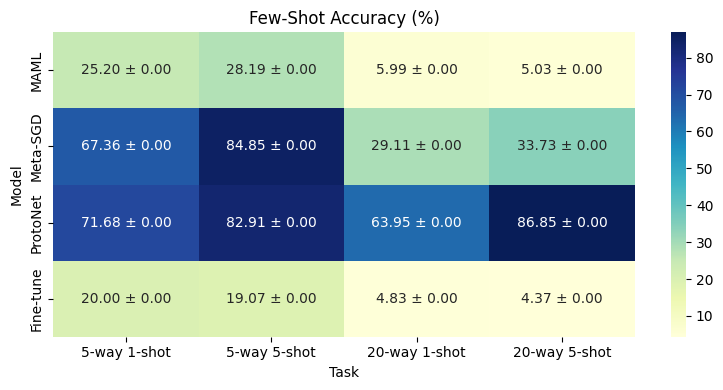

In [6]:
# 테이블
rows=[]
for model,d in results.items():
    row={"Model":model}
    for ways in WAYS_LIST:
        for shots in SHOTS_LIST:
            key=f"{ways}-way {shots}-shot"
            vals=np.array(d[key])*100
            row[key]=f"{vals.mean():.2f} ± {vals.std():.2f}"
    rows.append(row)
df=pd.DataFrame(rows).set_index("Model")
print("\n=== Few-Shot Accuracy (mean ± std, %) ===")
print(df)

# Heatmap
df_num=df.replace({r" ± .*":""},regex=True).astype(float)
plt.figure(figsize=(8,4))
sns.heatmap(df_num,annot=df.values,fmt="",cmap="YlGnBu")
plt.title("Few-Shot Accuracy (%)")
plt.xlabel("Task"); plt.ylabel("Model")
plt.tight_layout(); plt.show()
